<h1 align='center'>Fine-Tune BERT on Financial text Classification</h1>
<h3 align='center'>(Full Fine-tuning V/s LoRA)</h3>

## Preparing the Data

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset('nickmuchi/financial-classification')
raw_datasets

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/935 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/378k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/44.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4551 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/506 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4551
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 506
    })
})

In [2]:
split_datasets = raw_datasets['train'].train_test_split(train_size=0.8, seed=42)
split_datasets['validation'] = split_datasets.pop('test')
split_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 3640
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 911
    })
})

In [3]:
split_datasets['train'][0]

{'text': 'Incap Contract Manufacturing will carry out the manufacturing for these agreements at its factory in Tumkur , near Bangalore .',
 'labels': 1}

# Processing the Data

In [4]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)

model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

In [6]:
tokenized_datasets = split_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/3640 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

In [7]:
tokenized_datasets['train'].features

{'text': Value('string'),
 'labels': Value('int64'),
 'input_ids': List(Value('int32')),
 'token_type_ids': List(Value('int8')),
 'attention_mask': List(Value('int8'))}

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
training_args = TrainingArguments(
    output_dir='./results/full_finetuning',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs/full',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True
)

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [11]:
full_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1799248326.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  full_trainer = Trainer(


# Training and Evaluation

In [12]:
import time
import torch

start_time = time.time()
start_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0

full_trainer.train()
full_training_time = time.time() - start_time

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: utkarsh284 (utkarsh284-indira-gandhi-national-open-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.473300,0.381432,0.859495,0.856795,0.860602,0.859495
2,0.250700,0.436505,0.864984,0.862041,0.866073,0.864984
3,0.113500,0.524270,0.860593,0.861243,0.862605,0.860593


In [13]:
full_results = full_trainer.evaluate(tokenized_datasets['validation'])
print("Full Fine-tuning Results:")
full_results

Full Fine-tuning Results:


{'eval_loss': 0.4365048110485077,
 'eval_accuracy': 0.8649835345773875,
 'eval_f1': 0.8620409479760275,
 'eval_precision': 0.8660733779415904,
 'eval_recall': 0.8649835345773875,
 'eval_runtime': 4.7181,
 'eval_samples_per_second': 193.087,
 'eval_steps_per_second': 3.179,
 'epoch': 3.0}

In [14]:
full_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Full model trainable parameters: {full_params:,}")

Full model trainable parameters: 109,484,547


# LoRA Implementation

In [16]:
from peft import LoraConfig, get_peft_model, TaskType

model_lora = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['query', 'value']
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
lora_model = get_peft_model(model_lora, lora_config)
lora_model.print_trainable_parameters()

trainable params: 592,131 || all params: 110,076,678 || trainable%: 0.5379


In [18]:
lora_training_args = TrainingArguments(
    output_dir='./results/lora_finetuning',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=3e-4,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs/lora',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True
)

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3324242448.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


In [20]:
import time
import torch

start_time = time.time()
start_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0

lora_trainer.train()
lora_training_time = time.time() - start_time

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.700400,0.608273,0.754116,0.733150,0.750454,0.754116
2,0.424200,0.427550,0.824369,0.818736,0.826534,0.824369
3,0.351700,0.403018,0.843030,0.841747,0.841878,0.843030


In [21]:
print(f"LoRA training Time: {lora_training_time} seconds")

LoRA training Time: 194.8431680202484 seconds


In [22]:
lora_results = lora_trainer.evaluate(tokenized_datasets['validation'])
print("LoRA Results: ")
lora_results

LoRA Results: 


{'eval_loss': 0.40301772952079773,
 'eval_accuracy': 0.8430296377607025,
 'eval_f1': 0.8417469063906007,
 'eval_precision': 0.8418780183745573,
 'eval_recall': 0.8430296377607025,
 'eval_runtime': 3.9464,
 'eval_samples_per_second': 230.845,
 'eval_steps_per_second': 3.801,
 'epoch': 3.0}

In [23]:
lora_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"LoRA Trainable Parameters: {lora_params:,}")

LoRA Trainable Parameters: 592,131


# Performance Comparison

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

comparison_data = {
    'Method': ['Full fine-tuning', 'LoRA'],
    'Accuracy': [full_results['eval_accuracy'], lora_results['eval_accuracy']],
    'F1 Score': [full_results['eval_f1'], lora_results['eval_f1']],
    'Precision': [full_results['eval_precision'], lora_results['eval_precision']],
    'Recall': [full_results['eval_recall'], lora_results['eval_recall']],
    'Training Time (min)': [full_training_time/60, lora_training_time/60],
    'Trainable Parameters': [full_params, lora_params],
    'Parameter Efficiency': [100, (lora_params/full_params)*100]
}

comparison_df = pd.DataFrame(comparison_data)

In [26]:
print('\n=== PERFORMANCE COMPARISON ===')
print(comparison_df.to_string(index=False))


=== PERFORMANCE COMPARISON ===
          Method  Accuracy  F1 Score  Precision   Recall  Training Time (min)  Trainable Parameters  Parameter Efficiency
Full fine-tuning  0.864984  0.862041   0.866073 0.864984             4.965378             109484547            100.000000
            LoRA  0.843030  0.841747   0.841878 0.843030             3.247386                592131              0.540835


In [38]:
def calculate_costs(training_time_hours, gpu_type='T4'):
    gpu_costs = {
        "V100": 2.48,  # $/hour on cloud
        "A100": 4.10,  # $/hour on cloud
        "T4": 0.52     # $/hour on cloud
    }
    return training_time_hours * gpu_costs.get(gpu_type, 0.52)

full_cost = calculate_costs(full_training_time / 3600)
lora_cost = calculate_costs(lora_training_time / 3600)

cost_analysis = {
    'Method': ['Full Fine-tuning', 'LoRA'],
    'Training Cost ($)': [full_cost, lora_cost],
    'Storange (MB)': [
        sum(p.numel() * 4 for p in model.parameters()) / 1e6,   # 4 bytes per float32
        sum(p.numel() * 4 for p in lora_model.parameters() if p.requires_grad) / 1e6
    ],
    'Cost Reduction': ['Baseline', f'{((full_cost - lora_cost) / full_cost) * 100:.1f}%']
}

cost_df = pd.DataFrame(cost_analysis)
print('\n=== COST ANALYSIS ===')
print(cost_df.to_string(index=False))


=== COST ANALYSIS ===
          Method  Training Cost ($)  Storange (MB) Cost Reduction
Full Fine-tuning           0.043033     437.938188       Baseline
            LoRA           0.028144       2.368524          34.6%


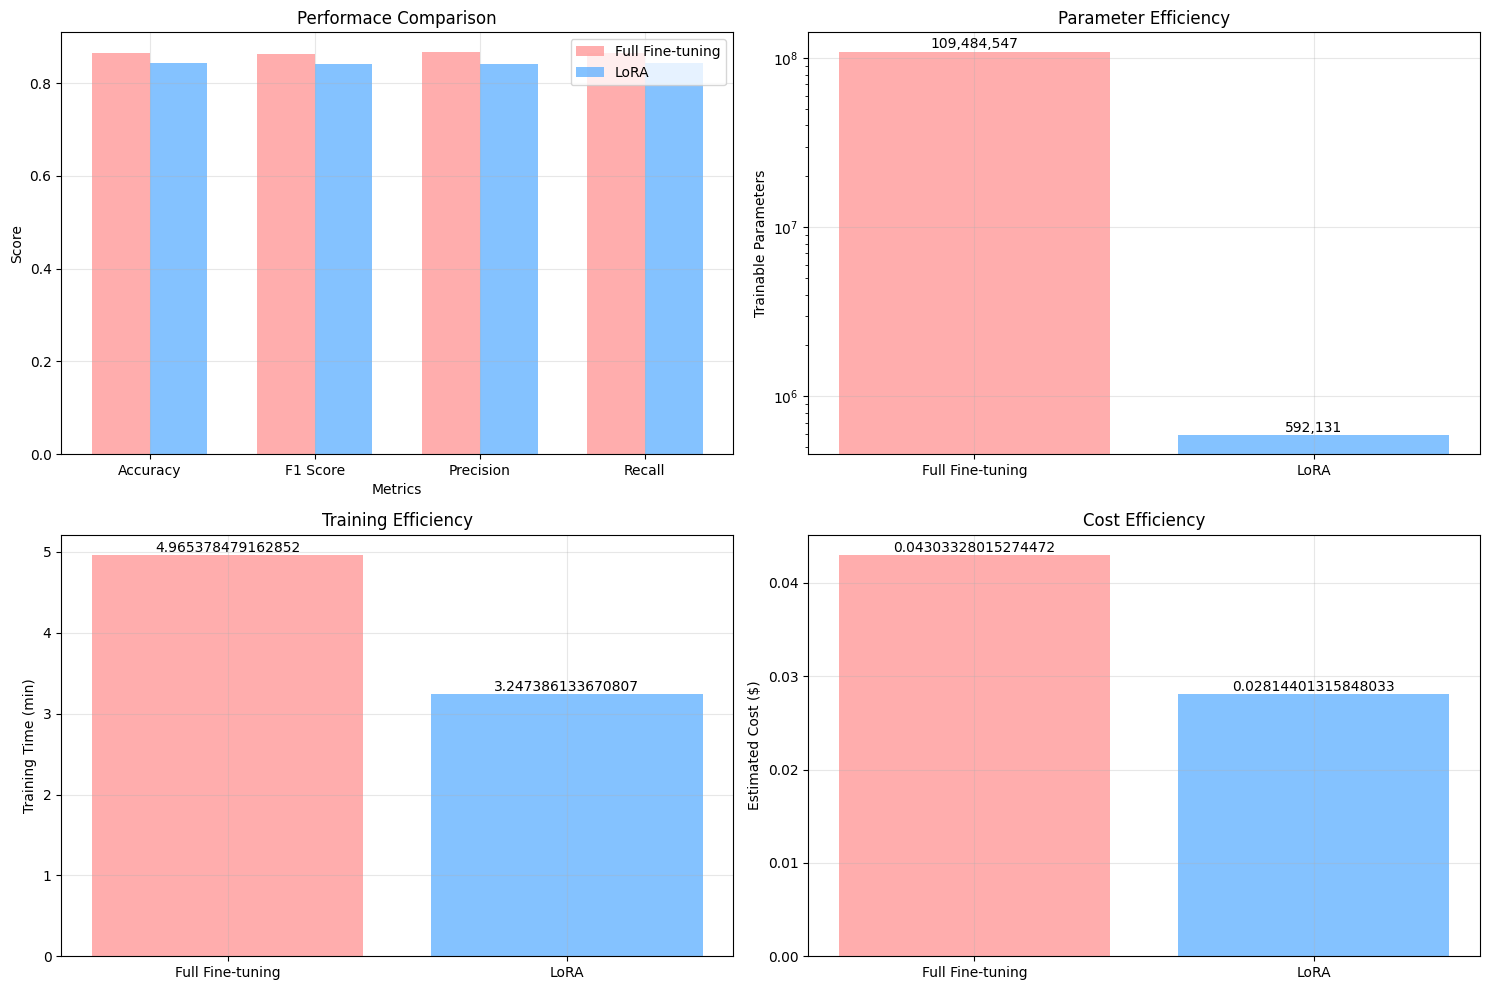

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy and F1 score

metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
full_scores = [full_results['eval_accuracy'], full_results['eval_f1'],
               full_results['eval_precision'], full_results['eval_recall']]
lora_scores = [lora_results['eval_accuracy'], lora_results['eval_f1'],
               lora_results['eval_precision'], lora_results['eval_recall']]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, full_scores, width, label='Full Fine-tuning',
        color='#ff9999', alpha=0.8)
ax1.bar(x + width/2, lora_scores, width, label='LoRA',
        color='#66b3ff', alpha=0.8)
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Performace Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)


# Parameter Efficiency

methods = ['Full Fine-tuning', 'LoRA']
param_counts = [full_params, lora_params]

ax2.bar(methods, param_counts, color=['#ff9999', '#66b3ff'], alpha=0.8)
ax2.set_ylabel('Trainable Parameters')
ax2.set_title('Parameter Efficiency')
ax2.set_yscale('log')
for i, v in enumerate(param_counts):
    ax2.text(i, v, f'{v:,}', ha='center', va='bottom')
ax2.grid(True, alpha=0.3)


# Training Time Comparison

times = [full_training_time/60, lora_training_time/60]
ax3.bar(methods, times, color=['#ff9999', '#66b3ff'], alpha=0.8)
ax3.set_ylabel('Training Time (min)')
ax3.set_title('Training Efficiency')
for i, v in enumerate(times):
    ax3.text(i, v, f'{v:,}', ha='center', va='bottom')
ax3.grid(True, alpha=0.3)


# Cost Analysis

costs = [full_cost, lora_cost]
ax4.bar(methods, costs, color=['#ff9999', '#66b3ff'], alpha=0.8)
ax4.set_ylabel('Estimated Cost ($)')
ax4.set_title('Cost Efficiency')
for i, v in enumerate(costs):
    ax4.text(i, v, f'{v:,}', ha='center', va='bottom')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('financial_bert_comparison.png', dpi=300, bbox_inches='tight')
plt.show()